# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv("train_2kmZucJ.csv")
test = pd.read_csv("test_12QyDcx.csv")

In [3]:
test['label'] = np.nan
df = pd.concat((train,test), axis=0)

# Inspect Data

In [4]:
df.head()

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [5]:
df.isnull().sum()

id          0
label    1953
tweet       0
dtype: int64

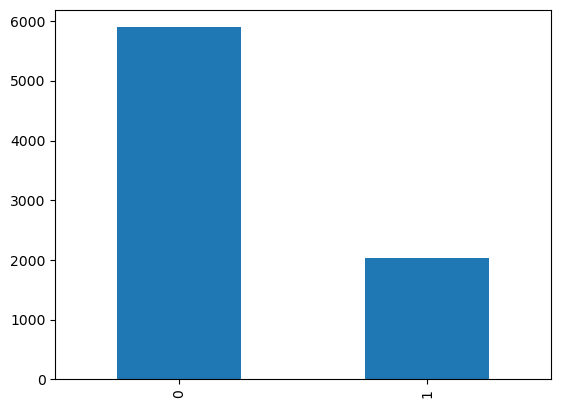

In [6]:
train['label'].value_counts().plot(kind='bar');

In [7]:
print(train['label'].value_counts(normalize=True))

0    0.744192
1    0.255808
Name: label, dtype: float64


# Clean Data

In [8]:
df = df.reset_index()

### Remove Links

In [9]:
df['tweet'][0]

'#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

In [10]:
for i in range(len(df['tweet'])):
    df['tweet'][i] = re.sub(r'http\S+', '', df['tweet'][i])
    df['tweet'][i] = re.sub(r'http:\S+', '', df['tweet'][i])

In [11]:
df['tweet'][0]

'#fingerprint #Pregnancy Test  #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

### Remove User Mentions

In [12]:
train["tweet"][14]

'@shaqlockholmes @sam_louise1991 the battery is so painful! I charge it overnight and by lunchtime battery is dead! #HateOrange.'

In [13]:
for i in range(len(df['tweet'])):
    df['tweet'][i] = re.sub(r'@[A-Za-z0-9_]+', '', df['tweet'][i])

In [14]:
df["tweet"][14]

'  the battery is so painful! I charge it overnight and by lunchtime battery is dead! #HateOrange.'

### Deal with Contractions

In [15]:
df['tweet'][3]

"I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home "

In [16]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [17]:
for i in range(len(df['tweet'])):
    df['tweet'][i] = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in df['tweet'][i].split(" ")])
    df['tweet'][i] = re.sub(r"'s\b","",df['tweet'][i])

In [18]:
df['tweet'][3]

'I am wired I know I am George I was made that way ;) #iphone #cute #daventry #home '

### Convert to Lower Case and Restrict to Letters

In [19]:
for i in range(len(df['tweet'])):
    df['tweet'][i] = re.sub("[^a-zA-Z]", " ", df['tweet'][i])
    df['tweet'][i] = df['tweet'][i].lower()

In [20]:
df['tweet'][0:10]

0     fingerprint  pregnancy test   android  apps  ...
1    finally a transparant silicon case    thanks t...
2    we love this  would you go   talk  makememorie...
3    i am wired i know i am george i was made that ...
4    what amazing service  apple will not even talk...
5    iphone software update fucked up my phone big ...
6    happy for us     instapic  instadaily  us  son...
7    new type c charger cable  uk     bay  amazon  ...
8    bout to go shopping again listening to music  ...
9    photo   fun  selfie  pool  water  sony  camera...
Name: tweet, dtype: object

### Remove Stop Words

In [21]:
train['tweet'][1]

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'

In [22]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patwh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
for i in range(len(df['tweet'])):
    sentence = df['tweet'][i].split()
    sentence = [w for w in sentence if w not in stop_words]
    df['tweet'][i] = " ".join(sentence).strip()

In [24]:
df['tweet'][1]

'finally transparant silicon case thanks uncle yay sony xperia sonyexperias'

### Lemmatization

In [25]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patwh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patwh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
lemmatizer = WordNetLemmatizer()

for i in range(len(df['tweet'])):
    sample = df['tweet'][i]
    splits = sample.split()
    sentence = " ".join(lemmatizer.lemmatize(w) for w in splits)
    df['tweet'][i] = sentence

### Multiple Spaces

In [27]:
for i in range(len(df['tweet'])):
    words = df['tweet'][i].split()                              
    df['tweet'][i] = " ".join(words).strip()

In [28]:
df['tweet'][0:10]

0    fingerprint pregnancy test android apps beauti...
1    finally transparant silicon case thanks uncle ...
2    love would go talk makememories unplug relax i...
3    wired know george made way iphone cute daventr...
4    amazing service apple even talk question unles...
5    iphone software update fucked phone big time s...
6    happy u instapic instadaily u sony xperia xperiaz
7    new type c charger cable uk bay amazon etsy ne...
8    bout go shopping listening music iphone justme...
9    photo fun selfie pool water sony camera picoft...
Name: tweet, dtype: object

# Feature Extraction

### Bag of Words (Count Vectorizer)

In [29]:
vectorizer = CountVectorizer()
bow_features = vectorizer.fit_transform(df['tweet'])

In [30]:
df_bow = pd.concat((df,pd.DataFrame(bow_features.toarray())), axis=1)
df_bow = df_bow.drop(columns=['index', 'tweet'])

### TDF-IF

In [31]:
vectorizer = TfidfVectorizer() 
tfidf_features = vectorizer.fit_transform(df['tweet'])

In [32]:
df_tfidf = pd.concat((df,pd.DataFrame(tfidf_features.toarray())), axis=1)
df_tfidf = df_tfidf.drop(columns=['index', 'tweet'])

# Classification

In [33]:
test_bow = df_bow[df_bow['label'].isnull()]
test_tfidf = df_tfidf[df_tfidf['label'].isnull()]

df_bow = df_bow[df_bow['label'].notnull()]
df_tfidf = df_tfidf[df_tfidf['label'].notnull()]

train_bow = df_bow[df_bow['label'].notnull()]
train_tfidf = df_tfidf[df_tfidf['label'].notnull()]

In [34]:
X_bow = train_bow.drop(columns = ['label', 'id'])
y_train = train_bow['label']
X_tfidf = train_tfidf.drop(columns = ['label', 'id'])

### Train/Validation Split

In [35]:
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(X_bow, y_train,test_size=0.3,random_state=123) 
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(X_tfidf,y_train,test_size=0.3,random_state=123) 

### Logistic Regression

In [36]:
# BOW

In [37]:
model = LogisticRegression()
model_fit = model.fit(X_train_bow, y_train_bow)
prediction = model_fit.predict(X_val_bow)
f1_score(y_val_bow, prediction)

0.7437011294526499

In [38]:
# TF-IDF

In [39]:
model = LogisticRegression()
model_fit = model.fit(X_train_tfidf, y_train_tfidf)
prediction = model_fit.predict(X_val_tfidf)
f1_score(y_val_tfidf, prediction)

0.6812749003984064

### Gaussian NB

In [40]:
# BOW

In [41]:
model = GaussianNB()
model_fit = model.fit(X_train_bow, y_train_bow)
prediction = model_fit.predict(X_val_bow)
f1_score(y_val_bow, prediction)

0.6201438848920864

In [42]:
# TF-IDF

In [43]:
model = GaussianNB()
model_fit = model.fit(X_train_tfidf, y_train_tfidf)
prediction = model_fit.predict(X_val_tfidf)
f1_score(y_val_tfidf, prediction)

0.6051282051282051

### Multinomial NB

In [44]:
# BOW

In [45]:
model = MultinomialNB()
model_fit = model.fit(X_train_bow, y_train_bow)
prediction = model_fit.predict(X_val_bow)
f1_score(y_val_bow, prediction)

0.7916666666666666

In [46]:
# TF-IDF

In [47]:
model = MultinomialNB()
model_fit = model.fit(X_train_tfidf, y_train_tfidf)
prediction = model_fit.predict(X_val_tfidf)
f1_score(y_val_tfidf, prediction)

0.5361305361305362

# Model Tuning

### Logistic Regression on BOW

In [48]:
Cs = np.array([1,0.1,0.01,0.001])
penalty = np.array(['l1', 'l2', 'elasticnet', 'none'])
class_weight = np.array(['balanced', None])

param_grid = dict(C=Cs, penalty=penalty, class_weight=class_weight) 
model = LogisticRegression()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

grid.fit(X_train_bow, y_train_bow)

score = round(grid.best_score_,3)
print('score: ', score)
print('c: ', grid.best_estimator_.C)
print('class weight: ', grid.best_estimator_.class_weight)
print('penalty: ', grid.best_estimator_.penalty)
print('solver: ', grid.best_estimator_.solver)

score:  0.781
c:  1.0
class weight:  balanced
penalty:  l2
solver:  lbfgs


### Multinomial Naive Bayes on BOW

In [49]:
alpha = np.array([1000,100,10,1])
fit_prior = np.array([True, False])

param_grid = dict(alpha=alpha, fit_prior=fit_prior) 
model = MultinomialNB()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

grid.fit(X_train_bow, y_train_bow)

score = round(grid.best_score_,3)
print('score: ', score)
print('alpha: ', grid.best_estimator_.alpha)
print('fit_prior: ', grid.best_estimator_.fit_prior)

score:  0.786
alpha:  1
fit_prior:  False


# Performance Upon Validation Set

In [50]:
model = MultinomialNB(alpha=1, fit_prior=True)
model_fit = model.fit(X_train_bow, y_train_bow)
prediction = model_fit.predict(X_val_bow)
f1_score(y_val_bow, prediction)

0.7916666666666666

# Predictions Upon Test Set

In [52]:
test_bow.index = test_bow['id']
test_bow = test_bow.drop(columns = 'id')

In [54]:
test_bow = test_bow.drop(columns = 'label')

In [57]:
prediction = model_fit.predict(test_bow)

In [60]:
test_bow['label'] = prediction
submission = test_bow['label']
submission_df = pd.DataFrame(submission)
submission_df

,label
id,
7921,1.0
7922,1.0
7923,1.0
7924,1.0
7925,1.0
...,...
9869,1.0
9870,0.0
9871,1.0


# Submission of Predictions

In [62]:
submission_df.to_csv('submission.csv')